In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize
import hickle as hkl

Using TensorFlow backend.


In [2]:
path = "../models/april-27-ft/master/" # master
#path = '../models/malawi/138-85-9/'
#path = '../models/cameroonniger/140-77-2/' # niger
#path = '../models/cameroonniger/127-81-8/' # cameroon
new_saver = tf.train.import_meta_graph(path + 'model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(path))


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/april-27-ft/master/model


In [3]:
LANDSCAPE = 'guatemala-coban'
INPUT = "../tile_data/{}/processed/".format(LANDSCAPE)
OUTPUT = "../tile_data/{}/output/".format(LANDSCAPE)
EPSG = CRS.WGS84

y_size = max([int(x) for x in os.listdir(INPUT) if any(i.isdigit() for i in x)])

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)

In [4]:
def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def calculate_epsg(coord):
    ''' Returns a UTM EPSG for a lat, long coord'''
    ___xx = 10 + ((coord[0] - (-126)) // 6)
    __x__ = 6 if coord[1] > 0 else 7
    return int( str(32) + str(__x__) + str(___xx)[:-2] )


def bounding_box(point, x_offset_max = 140, y_offset_max = 140, expansion = 10):
    # LONG, LAT FOR SOME REASON
    tl = point
    
    epsg = calculate_epsg(tl)
    tl = convertCoords(tl, 4326, epsg)
    
    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max )))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]
    
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]
    
    after = [b - a for a,b in zip(br, tl)]
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)
    
    min_x = tl[0] # original X offset - 10 meters
    max_x = br[0] # original X offset + 10*GRID_SIZE meters
    
    min_y = tl[1] # original Y offset - 10 meters
    max_y = br[1] # original Y offset + 10 meters + 140 meters
    # (min_x, min_y), (max_x, max_y)
    # (bl, tr)
    return [(min_x, min_y), (max_x, max_y)]

81 64 72 72 289


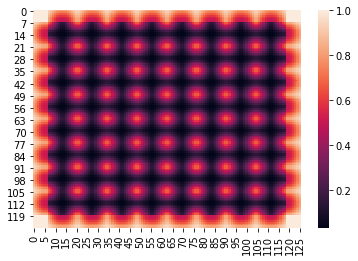

In [5]:
def fspecial_gauss(size, sigma):

    """Function to mimic the 'fspecial' gaussian MATLAB function
    """

    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

arr = fspecial_gauss(14, 3.5)
arr = arr[:7, :7]


SIZE = 9
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)


arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums
sns.heatmap(normal)

In [12]:
min_all = [0.01872335869818926,
 0.03467957343906164,
 0.021185510214418172,
 0.08898216009140014,
 0.052402322441339494,
 0.07628638863563539,
 0.083824477866292,
 0.08768215030431747,
 0.05718051139265299,
 0.0372315139323473,
 0.0,
 0.007564654648303981,
 -0.019136652257293465,
 0.0064204379683360435,
 0.006225000135600567,
 4.999999873689376e-05]

max_all = [0.20792677521705638,
 0.2990041905641556,
 0.4360648360848427,
 0.5161105132102968,
 0.4825860628485681,
 0.4943232241272928,
 0.5178957056999209,
 0.5291672283411026,
 0.6659183305501939,
 0.6092100739479065,
 0.37346625328063965,
 0.7162704998254776,
 0.40363759160041823,
 0.6478493613004686,
 0.8438000082969666,
 0.15365000069141388]

def tile_images(arr, output_folder):
    i = 0
    # Normal
    images = []
    for x_offset, cval in enumerate([x for x in range(0, 126, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = 0
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Upright        
    for x_offset, cval in enumerate([x for x in range(7,  119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = 9*9
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)
            
    # Right
    for x_offset, cval in enumerate([x for x in range(7, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = (9*9)+(8*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Up
    for x_offset, cval in enumerate([x for x in range(0, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = (9*9)+(8*8)+(9*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
    return images
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)

def load_and_predict_folder(y_col, folder, overlap_filter = upright, normal_filter = normal):
    pred_files = [INPUT + str(y_col) + "/" + str(folder) + ".npy"]
    pred_x = []
    
    clipping_params = {
        'rmax': rmax,
        'rmin': rmin,
        'dmax': dmax
    }

    for i in range(len(pred_files)):
        x = np.load(pred_files[0])
        
        filtered = median_filter(x[0, :, :, 10], size = 5)
        filtered = np.reshape(filtered, (64, 2, 64, 2))
        filtered = np.mean(filtered, axis = (1, 3))
        filtered = resize(filtered, (128, 128), 0)
        x[:, :, :, 10] = np.stack([filtered] * 24)
        x = np.delete(x, 14, -1)
        x = tile_images(x, None)
  
    pred_x = np.stack(x)     
    
    for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[:, :, :, :, x] = np.clip(pred_x[:, :, :, :, x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[:, :, :, :, x] - midrange) / (rng / 2)
        pred_x[:, :, :, :, x] = standardized
        mins, maxs = (np.min(pred_x[:, :, :, :, x]), np.max(pred_x[:, :, :, :, x]))

    preds = []
    batches = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]
    for i in range(len(batches)-1):
        batch_x = pred_x[batches[i]:batches[i+1]]
        lengths = np.tile(np.array(24), (batch_x.shape[0], 1))
        batch_pred = sess.run(logits, feed_dict={inp:batch_x, 
                                                 clipping_params['rmax']: 5,
                                                 clipping_params['rmin']: 0,
                                                 clipping_params['dmax']: 3,
                                                 length:lengths}).reshape(batch_x.shape[0], 14, 14)
        for sample in range(batch_pred.shape[0]):
            preds.append(batch_pred[sample, :, :])
            
    preds_stacked = []
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0)
    stacked = stacked * normal
    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright

    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    return stacked

In [13]:
x = np.load(INPUT + "{}/{}.npy".format(str(0), str(0)))

def validate_tiling(arr):
    arr = arr
    preds = tile_images(arr, None)
    preds_stacked = []
    preds = np.stack(preds)
    preds = preds[:, 0, 1:-1, 1:-1, 0]
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0)
    print(stacked.shape)
    stacked = stacked * normal
        
    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright
        
    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    return stacked

x1 = validate_tiling(x)
sns.heatmap(x[0, 1:-1, 1:-1, 0] - x1) 

FileNotFoundError: [Errno 2] No such file or directory: '../tile_data/guatemala-coban/processed/0/0.npy'

In [14]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")

In [15]:
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")
rmax = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
rmin = tf.get_default_graph().get_tensor_by_name("Placeholder_5:0")
dmax = tf.get_default_graph().get_tensor_by_name("Placeholder_6:0")

In [37]:

from time import sleep
all_preds = []
for row in tnrange(34, 35):
    for column in range(4, 7):
        x = np.load(INPUT + "{}/{}.npy".format(str(row), str(column)))
        all_preds.append(x)
#all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 2)

In [38]:
idx = 0

1


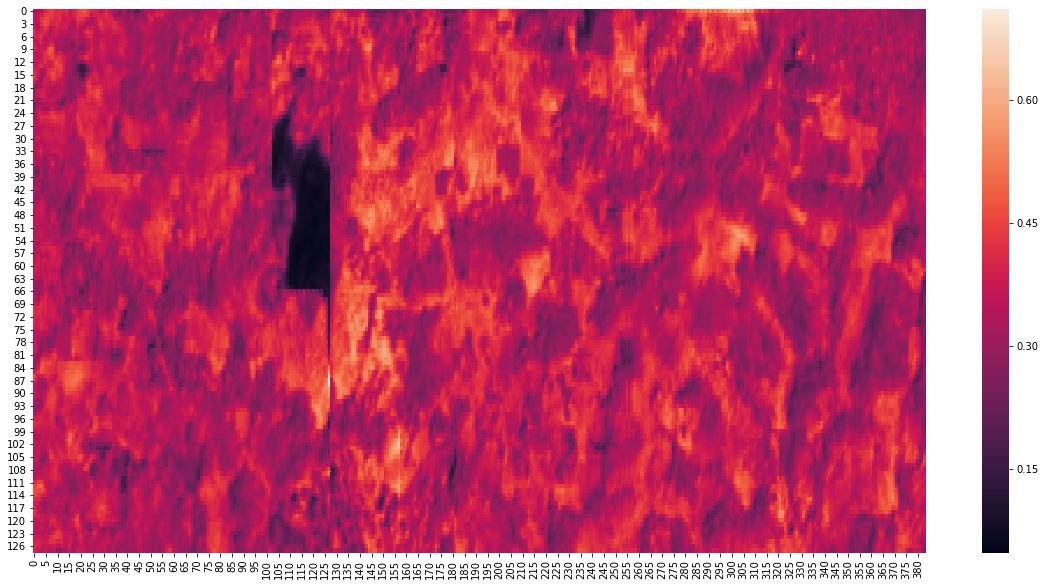

In [39]:
idx += 1
print(idx)
plt.figure(figsize=(20, 10))
#sns.heatmap(np.max(stacked[:, :, :, 4], 0) - np.min(stacked[:, :, :, 4], 0))
sns.heatmap(stacked[idx, :, :, 3])

In [40]:
from time import sleep
all_preds = []
for row in range(34, 35):
    pred_i = [load_and_predict_folder(row, col) for col in tnrange(0, 7)]
    pred_i = np.concatenate(pred_i, axis = 1)
    np.save(OUTPUT + str(row) + ".npy", pred_i)
    all_preds.append(pred_i)
    sleep(3)
all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 0)

In [41]:
files = sorted([int(x[:-4]) for x in os.listdir(OUTPUT) if ".npy" in x])
files = [34]
max_y = np.max(files)
preds = [np.load(OUTPUT + str(file) + ".npy") for file in files]
preds.reverse()
preds = np.concatenate(preds, axis = 0)

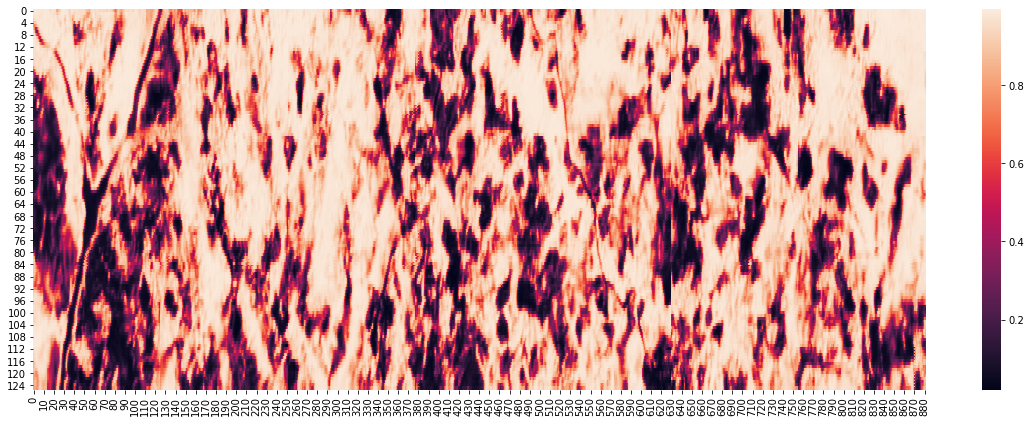

In [42]:
# Epoch 71
preds[np.isnan(preds)] = 0.
plt.figure(figsize=(20, 2*(20/10)*2 - 1))
sns.heatmap(preds)
stacked = preds
#plt.savefig('ghana.png', dpi = 300)

In [16]:
thresh = 0.4 # .125, 0.3 is best rn
thresh_p = 0.55

for window_x in range(2, stacked.shape[0]-2, 1):
    for window_y in range(2, stacked.shape[1]-2, 1):
        l, r, u, d =  False, False, False, False
        cur_window = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
        hor_vert_neighbors = False
        if (cur_window[2, 2] > thresh and
            cur_window[2, 2] < thresh_p):
            if cur_window[3, 2] > thresh * 2 and cur_window[4, 2] < thresh * 2 :
                hor_vert_neighbors = True
                r = True
            if cur_window[1, 2] > thresh * 2 and cur_window[2, 0] < thresh * 2:
                hor_vert_neighbors = True
                l = True
            if cur_window[2, 3] > thresh * 2 and cur_window[2, 4] < thresh * 2:
                hor_vert_neighbors = True
                d = True
            if cur_window[2, 1] > thresh * 2 and cur_window[2, 0] < thresh * 2:
                hor_vert_neighbors = True
                u = True
        passes = False
        if r and not l:
            passes = True
        if l and not r:
            passes = True
        if d and not u:
            passes = True
        if u and not d:
            passes = True
        
        if passes:
            if r:
                if cur_window[1, 1] < thresh * 2 and cur_window[1, 3] < thresh * 2:
                    #print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
            
            if l:
                if cur_window[3, 1] < thresh * 2 and cur_window[3, 3] < thresh * 2:
                    #print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if u:
                if cur_window[1, 3] < thresh * 2 and cur_window[3, 3] < thresh * 2:
                    #print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if d:
                if cur_window[1, 1] < thresh * 2 and cur_window[3, 1] < thresh * 2:
                    #print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            #n_offenders = 0
                
                #print(cur_window)

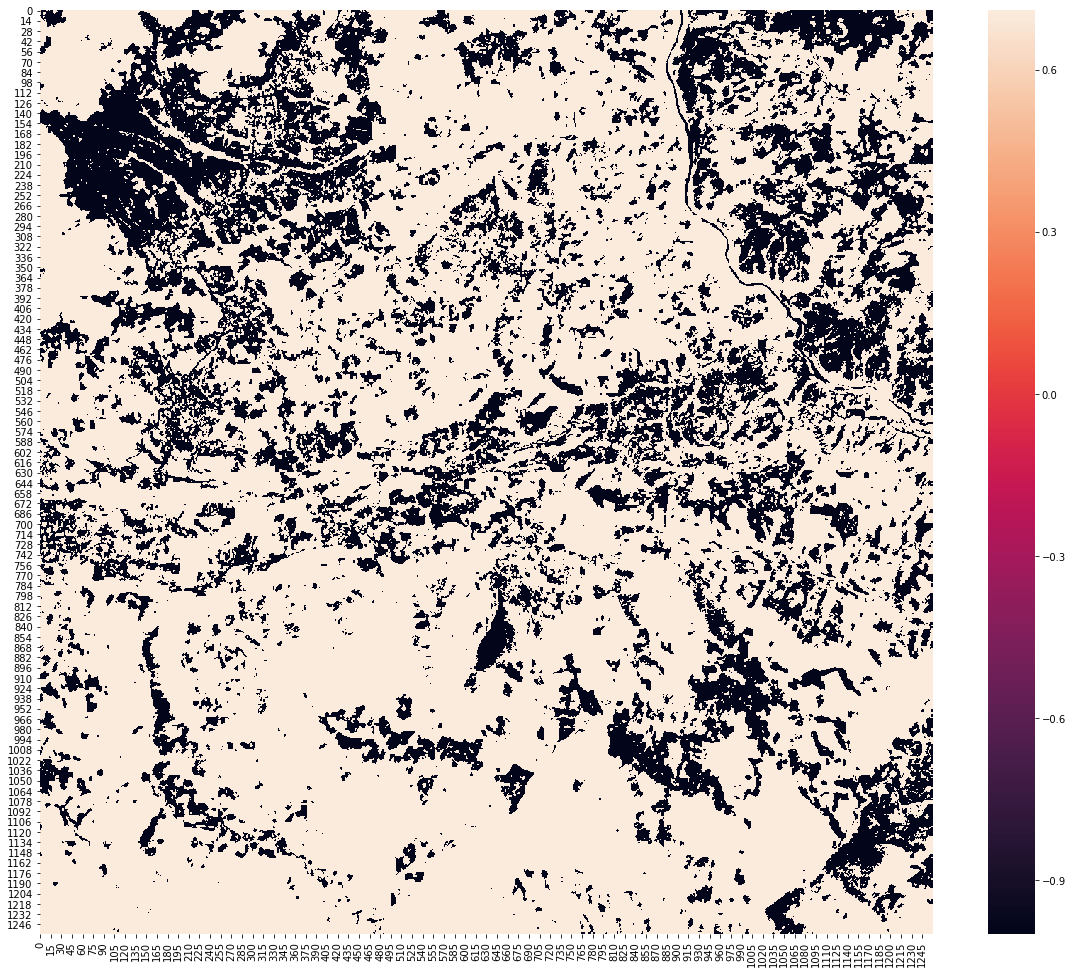

In [17]:
#stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, ((20/10)*10 - 3)))
stacked[np.where(stacked > thresh_p)] = 0.71
stacked[np.where(stacked < thresh_p)] = -1
stacked[np.where(stacked == 1.0)] = 1.
sns.heatmap(stacked)

In [22]:
landscapes = {
    'ethiopia-tigray': (13.540810, 38.177220),
    'kenya-makueni-2': (-1.817109, 37.44563),
    'ghana': (9.259359, -0.83375),
    'niger-koure': (13.18158, 2.478),
    'cameroon-farnorth': (10.596, 14.2722),
    'mexico-campeche': (18.232495, -92.1234215),
    'malawi-rumphi': (-11.044, 33.818),
    'ghana-sisala-east': (10.385, -1.765),
    'ghana-west-mamprusi': (10.390084, -0.846330),
    'ghana-kwahu': (6.518909, -0.826008),
    'senegal': (15.82585, -15.34166),
    'india-kochi': (9.909, 76.254),
    'india-sidhi': (24.0705, 81.607),
    'brazil-esperito-santo': (-20.147, -40.837),
    'brazil-paraiba': (-22.559943, -44.186629),
    'brazil-goias': (-14.905595, -48.907399),
    'colombia-talima': (4.179529, -74.889171),
    'drc-kafubu': (-11.749636, 27.586622),
    'thailand-khon-kaen': (15.709725, 102.546518),
    'indonesia-west-java': (-6.721101, 108.280949),
    'madagascar': (-18.960152, 47.469587),
    'tanzania': (-6.272258, 36.679824),
    'chile': (-36.431237, -71.872030),
    'indonesia-jakarta': (-6.352580, 106.677072),
    'caf-baboua': (5.765917, 14.791618),   
    'honduras': (14.096664, -88.720304),
    'nicaragua': (12.398014, -86.963042),
    'china': (26.673679, 107.464231),
    'australia-west': (-32.666762, 117.411197),
    'mexico-sonora': (29.244288, -111.243230),
    'south-africa': (-30.981698, 28.727301),
    'uraguay-maldonado': (-34.629250, -55.004331),
    'dominican-rep-la-salvia': (18.872589, -70.462961),
    'guatemala-coban': (15.3, -90.8)
}

landscape = 'guatemala-coban'

#coords = (7.702058, -0.709011) # brong ahafo, bono east
#coords = (7.398111, -1.269223) # cocoa
#coords = (16.032170, -90.144511) # Guatemala
#coords = (13.757749, -90.004949) # elsalvador imposible
#coords = (13.727334, -90.015579) # elsalvador imposible2
#coords = (13.933745, -84.690842) # Bonanza, Nicaragua
coords = landscapes[landscape]
coords = (coords[1], coords[0])
#bl = bounding_box(coords, (0*1260)+0, (1*1260)-0, expansion = 0) # -85, +135 el salv
#bl = bounding_box(coords, 370, 1220, expansion = 0)
#coords = (bl[0][0], bl[0][1])
#p#oint = bounding_box(coords, 370+650, 1220+600, expansion = 0)
point = bounding_box(coords, (10*1260), ((max_y+1)*1260)+50, expansion = 0) # -85, +135 el salv # +10, -220 hond
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]

In [23]:
stacked[np.where(stacked < 0)] = 0.
stacked = stacked.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = stacked.shape[1], height = stacked.shape[1])
print("Writing" + '../../ce-hosting/includes/{}.tif'.format(landscape))
new_dataset = rasterio.open('../../ce-hosting/includes/{}.tif'.format(landscape), 'w', driver = 'GTiff',
                           height = stacked.shape[1], width = stacked.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(stacked, 1)
new_dataset.close()

Writing../../ce-hosting/includes/guatemala-coban.tif


# Cloud optimized Geotiff

In [19]:
!gdal_translate ../../ce-hosting/includes/dominican-rep-la-salvia.tif ../tile_data/cog/dominican-rep-la-salvia.tif \
               -co TILED=YES -co COMPRESS=LZW
!gdaladdo -r average -ro ../tile_data/cog/dominican-rep-la-salvia.tif 2 4 8 16 32
#!gsutil cp niger.tif gs://restoration-hosting/niger.tif

Input file size is 630, 630
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


# Half-hectare tree density Geotiff

In [ ]:
summed = np.reshape(stacked, (stacked.shape[0] // 6, 6, stacked.shape[1] // 6, 6))
summed = np.sum(summed, (1, 3))
summed /= np.max(summed)
summed = np.clip(summed, 0, 0.8)
summed += 0.1

In [ ]:
plt.figure(figsize=(18, 15))
sns.heatmap(summed)

In [ ]:

summed = summed.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = summed.shape[1], height = summed.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/bonanza1.tif', 'w', driver = 'GTiff',
                           height = summed.shape[1], width = summed.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(summed, 1)
new_dataset.close()

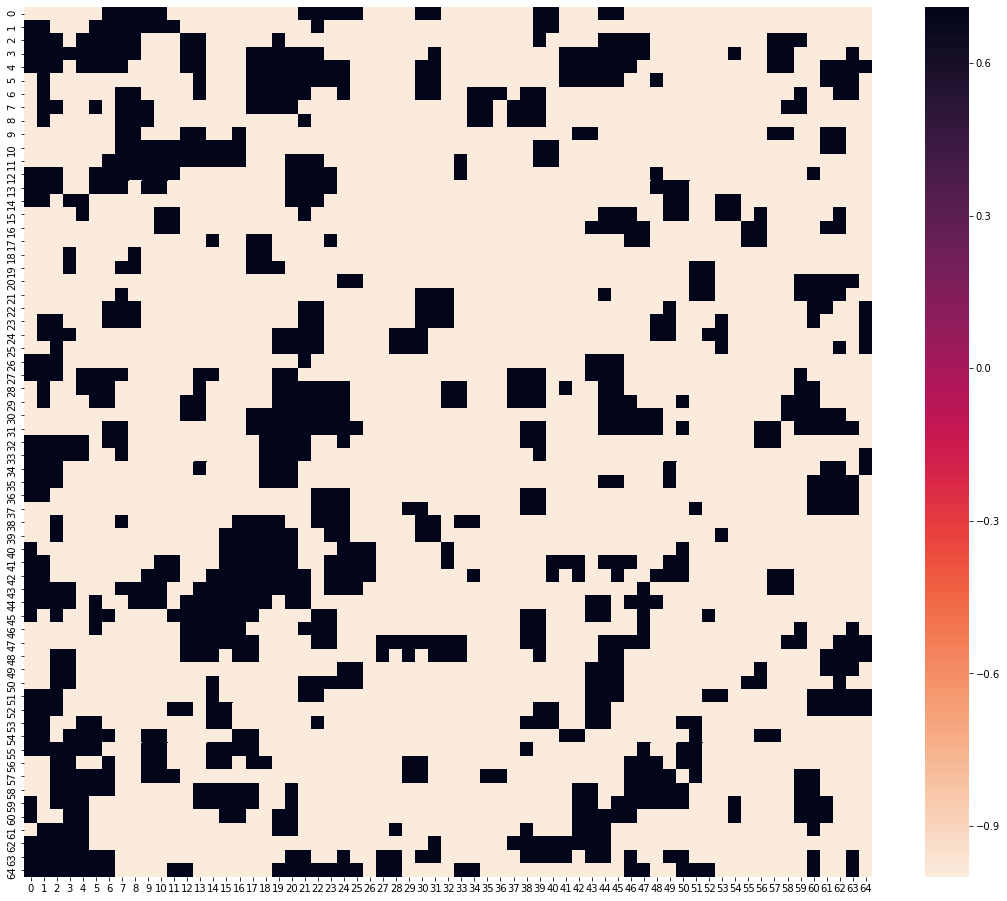

In [37]:
plt.figure(figsize=(19, 16)) # : ,96:155
sns.heatmap(stacked[340:405, 98:163], cmap = sns.cm.rocket_r)